# TP 4 Regression logistique avec régularisation
Dans ce TP, nous aimerions faire une classification binaire en utilisant la régression.

Pour ce faire, nous étudierons un ensemble de données avec la variable  (y) representant la commercialisation d'un produit et les caractéristiques (X) representant les résultat des tests de qualité test 1 et test 2 du produit.

La prédiction se fera avec l'agorithme de descente du gradient avec régularisation.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [5]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(118, 3)

Dans ces données (data), la première colonne represente la première note, la deuxieme colonne la deuxième note et la troisième colonne represente la commercialisation (1 oui 0 non).

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [7]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,0:2]))
y = data[:, 2];
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [8]:
print('X', X.shape ,' y ', y.shape)

X (118, 3)  y  (118, 1)


# Transformation de données
Dans cette partie, nous aimerions transformer nos données afin d'avoir une fonction polynomiale de degrée 6.

La fonction sera:

$x_0=1$

$x_1=x_1$

$x_2=x_2$

$x_3={x_1}^2$

$x_4={x_1}x_2$

$x_5={x_2}^2$

$x_6={x_1}^3$

$x_7={x_1}^2 x_2$

$x_8= x_1 {x_2}^2$

$x_9= {x_2}^3$

...


Pour un polynme de degrée 6 à 2 variables nous aurons 28 caracteristiques

**Question**: comment avons nous trouvé ce chiffre?

**Astuce**: référez vous aux probabilités

Reponse: On a 28 caractéristiques dans un polynôme de degré 6 à deux variables car il existe 28 combinaisons possibles (avec répétition) de x1x1​ et x2x2​ dont le degré total est inférieur ou égal à 6.

In [ ]:
def mapping(X):
    
    cols = 28
    degree=7
    outX= np.ones((X.shape[0],cols))
    X1=X[:,1]
    X2=X[:,2]
    k=0
    for i in range(degree):
        for j in range(i+1):
            outX[:, k] = np.power(X1,i-j)*(np.power(X2,j))
            k=k+1
    return outX    


In [74]:
X2=mapping(X)
X2.shape

(118, 28)

# Descente du Gradient : Préparation des fonctions

0- Fonction mpgistique (Sigmoid)

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    """
    Calcule la fonction sigmoïde de l'entrée z.

    Paramètre :
    - z : un scalaire, un vecteur ou une matrice (valeurs réelles)

    Retourne :
    - La transformation sigmoïde de z, avec des valeurs entre 0 et 1
    """
    return 1/(1+np.exp(-z))
 

1- Calcul du coût

Cette fonction servira à calculer le cout $J(\theta_0,\theta_1)$

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

Elle prendra l'ensemble de données d'apprentissage en entrée ainsi que les paramètres définis initialement

In [ ]:


def computeCostReg(X, y, theta, lambda_):
    """
    Calcule le coût (J) pour la régression logistique régularisée.

    Paramètres :
    - X : matrice des caractéristiques (m exemples, n caractéristiques)
    - y : vecteur des étiquettes (m x 1)
    - theta : vecteur des paramètres (n x 1)
    - lambda_ : paramètre de régularisation
    - la regularisation sert à éviter le sur-apprentissage

    Retour :
    - J : coût régularisé (valeur scalaire)
    """
    m = y.shape[0]  # nombre d'exemples

    # Hypothèses (probabilités prédites)
    h = 1 / (1 + np.exp(-X.dot(theta)))  # = Sigmoid(X @ theta)

    # Coût sans régularisation
    cost = (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

    # Régularisation (on exclut theta[0])
    reg = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))

    # Coût total
    J = cost + reg

    return J.item()  # .item() pour retourner un scalaire propre


2- Fonction de la descente du gradient

Cette fonction mettra à jour les paramètres $\theta_0,\theta_1$ jusqu'à convergence: atteinte du nombre d'itérations max, ou dérivée assez petite.

In [ ]:
   
def gradientDescent(X, y, theta, alpha, iterations, lambda_):
    # garder aussi le cout à chaque itération 
    # pour afficher le coût en fonction de theta0 et theta1
    """
    Effectue la descente du gradient pour la régression logistique régularisée.

    Paramètres :
    - X : matrice des caractéristiques (m x n)
    - y : vecteur des étiquettes (m x 1)
    - theta : vecteur des paramètres (n x 1)
    - alpha : taux d’apprentissage
    - iterations : nombre d’itérations à effectuer
    - lambda_ : paramètre de régularisation

    Retour :
    - theta : paramètres optimisés
    - J_history : liste des coûts à chaque itération (pour visualisation)
    """
    m = y.shape[0]
    J_history = []

    for i in range(iterations):
        h = 1 / (1 + np.exp(-X.dot(theta)))  # prédictions

        # Erreur
        error = h - y

        # Gradient
        gradient = (1/m) * X.T.dot(error)
        # Régularisation (on ne régularise pas theta[0])
        reg = (lambda_/m) * theta
        reg[0] = 0  # pas de régularisation pour le biais

        # Mise à jour de theta
        theta = theta - alpha * (gradient + reg)

        # Sauvegarde du coût pour analyse
        cost = computeCostReg(X, y, theta, lambda_)
        J_history.append(cost)

    return theta, J_history


# Descente du Gradient : Appel des fonctions

Initialisation de $\theta_0$ et $\theta_1$

In [ ]:
n=X.shape[1]
theta = np.zeros((n, 1))
theta

array([[0.],
       [0.],
       [0.]])

Calculer le cout initial

In [ ]:
lambda_ = 1
initialCost=computeCostReg(X, y, theta, lambda_)
print('cout initial')
print(initialCost)

cout initial : 0.6931471805599454

Appel des la fonction de calcul du gradient

In [ ]:
# paramètres
iterations = 1500;
alpha = 0.01;

# paramètre de regression
lambdaa = 1;

# Appel
theta, J_history = gradientDescent(X, y, theta, alpha, iterations, lambdaa)


cout finale : 0.6908867948445119

Traçage de la fonction du coût

Notons que $\theta^T  x$ est équivalent à $X  \theta $ où $X= \begin{pmatrix}
..(x^{(1)})^T..\\
..(x^{(2)})^T..\\
.\\
.\\
.\\
..(x^{(m)})^T..
\end{pmatrix} $

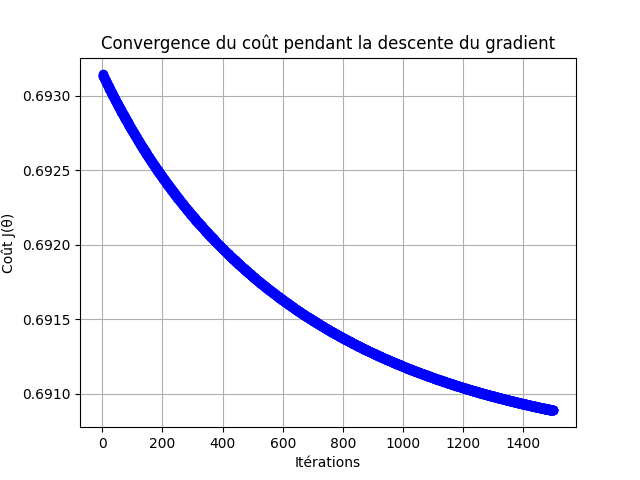

# Dessin de la limite de decision (Descision Boundary)
Dans cette partie, nous aimerions dessiner la ligne separatrice d nos données

In [ ]:

def drawCircle(X, y, theta):
    """
    Dessine les données (avec des cercles) et la frontière de décision pour la régression logistique.
    
    Paramètres :
    - X : matrice des caractéristiques (m x n) où n=2 dans le cas 2D
    - y : vecteur des étiquettes (m x 1)
    - theta : vecteur des paramètres du modèle (n x 1)
    """
    
    # On sépare les exemples de classe 0 et classe 1
    pos = y == 1  # classe 1
    neg = y == 0  # classe 0
    
    # Affichage des exemples (en utilisant des cercles)
    plt.scatter(X[pos, 1], X[pos, 2], marker='o', label='Classe 1', color='b')  # Classe 1 en bleu
    plt.scatter(X[neg, 1], X[neg, 2], marker='x', label='Classe 0', color='r')  # Classe 0 en rouge
    
    # Tracer la frontière de décision (quand h(x) = 0.5)
    # Pour simplifier, on peut imaginer une frontière linéaire dans le cas de X 2D
    # La condition de la frontière est theta_0 + theta_1 * x1 + theta_2 * x2 = 0
    # Réorganiser pour obtenir x2 en fonction de x1 : x2 = (-theta_0 - theta_1 * x1) / theta_2
    
    # Création d'une gamme de valeurs x1 pour dessiner la ligne
    x1_vals = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    # Calcul de x2 en fonction de x1 (frontière de décision)
    x2_vals = (-theta[0] - theta[1] * x1_vals) / theta[2]
    
    # Affichage de la frontière de décision
    plt.plot(x1_vals, x2_vals, label='Frontière de décision', color='g', linewidth=2)
    
    # Paramètres d'affichage
    plt.xlabel('Test 1 (x1)')
    plt.ylabel('Test 2 (x2)')
    plt.legend()
    plt.title('Limite de décision et données')
    plt.grid(True)
    plt.show()

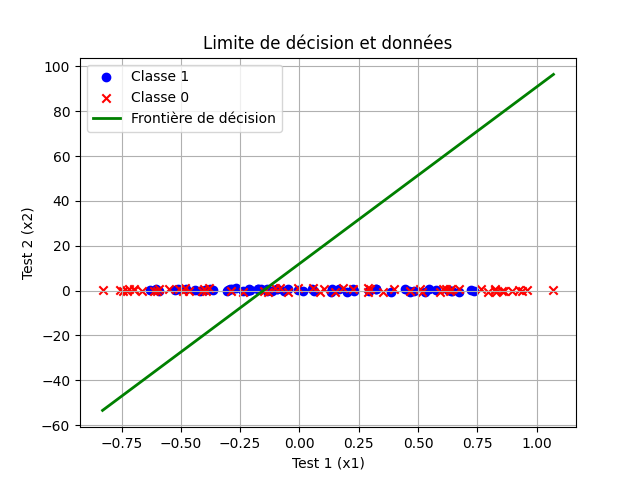

# Classification (Prédiction)
Ici il serait interessant de calculer la prédiction en utilisant un seuil
i.e. si h>seuil alors classe =1 sinon classe = 0

In [ ]:
def predict(X, theta, seuil=0.5):
    """
    Prédit les classes en fonction du seuil donné.
    
    Paramètres :
    - X : matrice des caractéristiques (m x n), avec m exemples et n caractéristiques
    - theta : vecteur des paramètres (n x 1)
    - seuil : seuil à partir duquel la classification est effectuée (par défaut 0.5)
    
    Retourne :
    - y_pred : vecteur des prédictions de classe (m x 1), où 1 = classe positive, 0 = classe négative
    """
    # Calcul des prédictions h_theta(x) = sigmoid(X * theta)
    h = Sigmoid(np.dot(X, theta))  # X est de taille (m x n) et theta est de taille (n x 1)
    
    # Appliquer le seuil pour prédire la classe
    y_pred = (h >= seuil).astype(int)  # Si h >= seuil, classe 1, sinon classe 0
    
    return y_pred



# Affichage 
Graphe representant les acceptations selon les caracteristiques

Text(0, 0.5, 'x 2')

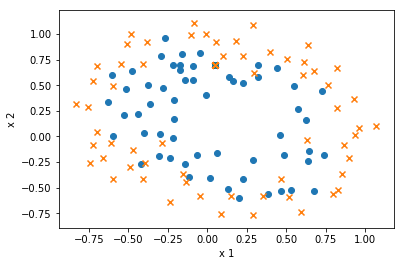

In [12]:
plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="y=1",marker ='o')
plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="y=0",marker ='x')

plt.xlabel('x 1')
plt.ylabel('x 2')

Traçage du coût en fonction de theta0 et theta1

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Étape 1 : créer une grille de valeurs pour theta0 et theta1
theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-10, 10, 100)

# Initialiser la matrice de coût
J_vals = np.zeros((len(theta0_vals), len(theta1_vals)))

# On garde les autres theta fixes (ou à 0 si il y a plus de 2 variables)
# ici on suppose que theta a au moins 3 éléments : theta0, theta1, theta2,...
for i in range(len(theta0_vals)):
    for j in range(len(theta1_vals)):
        t = np.copy(theta)
        t[0] = theta0_vals[i]
        t[1] = theta1_vals[j]
        # les autres thetas restent comme dans l'entraînement
        J_vals[i, j] = computeCostReg(X, y, t, lambdaa)

# Étape 2 : Tracer la surface 3D
theta0_vals_mesh, theta1_vals_mesh = np.meshgrid(theta0_vals, theta1_vals)

fig = plt.figure(figsize=(12, 5))

# Graphe 3D
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(theta0_vals_mesh, theta1_vals_mesh, J_vals.T, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel('Coût J(θ)')
ax.set_title('Surface du coût')

# Graphe de contour
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(theta0_vals, theta1_vals, J_vals.T, levels=np.logspace(-1, 3, 20), cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel(r'$\theta_1$')
ax2.set_title('Contours du coût J(θ)')
ax2.plot(theta[0], theta[1], 'rx', markersize=10, label='Minimum')
ax2.legend()

plt.tight_layout()
plt.show()


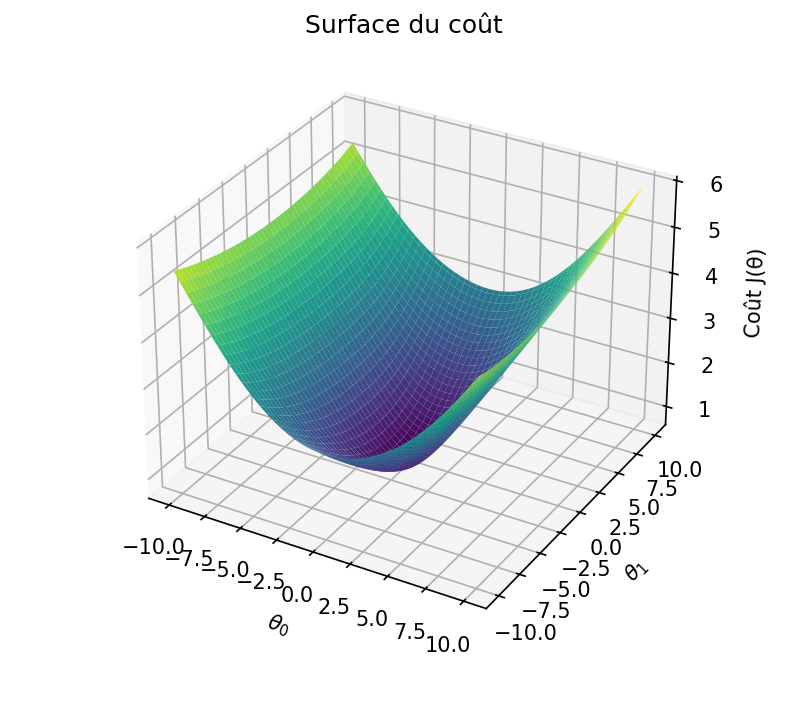

# Qualité du classifieur

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [78]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X)
prcision = np.mean(y==y_pred)*100

Précision du classifieur : 52.54%

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
#comparatif avec lalgo sklearn====================================================================================================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# ================================
# 1. Préparation des données (avec mapping comme le tien)
# ================================

X_sklearn = mapping(X)  # On utilise le même mapping que toi
y_sklearn = y.ravel()   # scikit-learn attend un vecteur 1D pour y

# ================================
# 2. Modèle scikit-learn
# ================================

# C = 1/lambda_, donc ici lambda_ = 1 => C = 1.0
start_time_sklearn = time.time()
model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1500)

# Entraînement
model.fit(X_sklearn, y_sklearn)

# Prédictions
y_pred_sklearn = model.predict(X_sklearn)
y_proba_sklearn = model.predict_proba(X_sklearn)[:, 1]

end_time_sklearn = time.time()
execution_time_sklearn_sl = (end_time_sklearn - start_time_sklearn) * 1000
# ================================
# 3. Évaluation
# ================================

# Coût initial (avec theta = 0)
theta_init = np.zeros(X_sklearn.shape[1])
initial_cost_sklearn = log_loss(y_sklearn, 1 / (1 + np.exp(-X_sklearn.dot(theta_init))))

# Coût final
final_cost_sklearn = log_loss(y_sklearn, y_proba_sklearn)

# Précision
accuracy_sklearn = accuracy_score(y_sklearn, y_pred_sklearn) * 100

# ================================
# 4. Affichage comparatif
# ================================

print("\n--- Comparaison ---")
print(f"Coût initial (mon modèle)      : {initialCost:.4f}")
print(f"Coût initial (scikit-learn)    : {initial_cost_sklearn:.4f}")
print(f"Coût final  (mon modèle)       : {J_history[-1]:.4f}")
print(f"Coût final  (scikit-learn)     : {final_cost_sklearn:.4f}")
print(f"Précision  (mon modèle)        : {precision:.2f}%")
print(f"Précision  (scikit-learn)      : {accuracy_sklearn:.2f}%")
print(f"Temps d'exécution (mon modèle) : {execution_time_mm:.2f} ms")
print(f"Temps d'exécution (scikit-learn): {execution_time_sklearn_sl:.2f} ms")

--- Comparaison ---

Coût initial (mon modèle)      : 0.6931 ||
Coût initial (scikit-learn)    : 0.6931

Coût final  (mon modèle)       : 0.6909 ||
Coût final  (scikit-learn)     : 0.4625

Précision  (mon modèle)        : 52.54% ||
Précision  (scikit-learn)      : 83.05%

Temps d'exécution (mon modèle) : 57.01 ms ||
Temps d'exécution (scikit-learn): 9.18 ms

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

- Appliquer une normalisation (ou standardisation) aux features
- tester plusieur lambda (le parametre de regularisation)
- utiliser la validation croisee